# How to achieve top 35% in House Price kaggle competition

載入相關的Package

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from datetime import datetime
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from mlxtend.regressor import StackingRegressor
from sklearn.metrics import mean_squared_error
from scipy.special import boxcox1p
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

接著就載入Training Data和Testing Data吧。

In [11]:
train = pd.read_csv('D:/kaggle/House Price/train.csv', index_col='Id')
test = pd.read_csv('D:/kaggle/House Price/test.csv', index_col='Id')
train.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
Id                                    ...                             
1          Lvl    AllPub    Inside    ...            0    NaN   NaN   
2          Lvl    AllPub       FR2    ...            0    NaN   NaN   
3          Lvl    AllPub    Inside    ...            0    NaN   NaN   
4          Lvl    AllPub    Corner    ...            0    NaN   NaN   
5          Lvl    AllPub       FR2    ...            0    NaN   NaN   

   MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                         
1          NaN       0      2    2008        WD         Normal     208500  
2          NaN       0      5    2007        WD         Normal     181500  
3          NaN       0      9    2008        WD         Normal     223500  
4          NaN       0      2    2006        WD        Abnorml     140000  
5          NaN       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

根據資料集來源的文件指出，在Training Data中有OutLier(特別是當欄位'GrLivArea' > 4000以及欄位'SalePrice' < 300000時)，透過散佈圖來看看它與Label的關係。

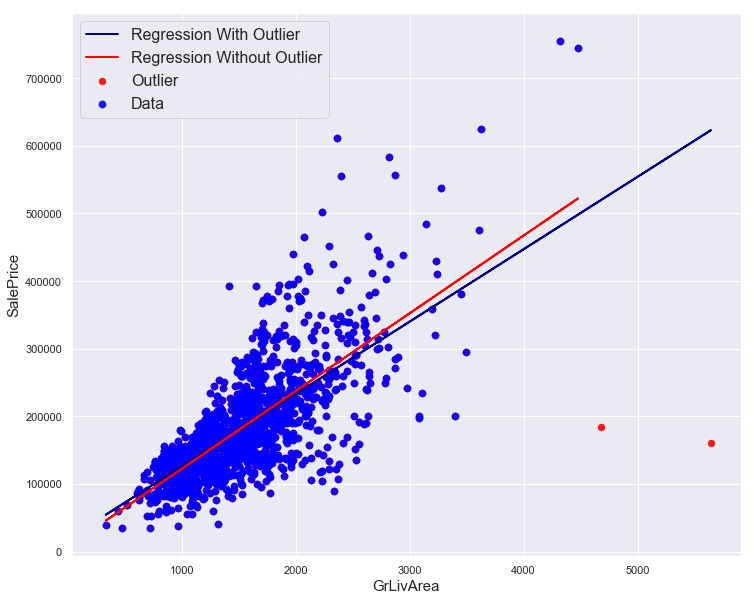

In [12]:
reg_outlier = LinearRegression().fit(train['GrLivArea'].values.reshape(-1,1),  train['SalePrice'])
pred = reg_outlier.predict(train.GrLivArea.values.reshape(-1,1))
train_without_outlier = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
reg_without_outlier = LinearRegression().fit(train_without_outlier['GrLivArea'].values.reshape(-1,1),  train_without_outlier['SalePrice'])
pred_without_outlier = reg_without_outlier.predict(train_without_outlier.GrLivArea.values.reshape(-1,1))
plt.figure(figsize=(12, 10))
plt.scatter(train.GrLivArea, 
            train.SalePrice, 
            s = 50, # 設置點的大小
            c = 'red', # 設置點的顏色
            marker = 'o', # 設置點的形狀
            alpha = 0.9, # 設置點的透明度
            linewidths = 0.3, # 設置散點邊界的粗細
            label = "Outlier"
            )
plt.scatter(train_without_outlier.GrLivArea, 
            train_without_outlier.SalePrice, 
            s = 55, # 設置點的大小
            c = 'blue', # 設置點的顏色
            marker = 'o', # 設置點的形狀
            alpha = 0.9, # 設置點的透明度
            linewidths = 0.3, # 設置散點邊界的粗細
            label = "Data"
           )
# 繪製迴歸線
plt.plot(train.GrLivArea, pred, linewidth = 2,  c = 'darkblue', label = "Regression With Outlier")
plt.plot(train_without_outlier.GrLivArea, pred_without_outlier, linewidth = 2, c = 'red', label = 'Regression Without Outlier')
plt.xlabel('GrLivArea', fontsize=15)
plt.ylabel('SalePrice', fontsize=15)
plt.legend(prop={'size': 16})

根據文獻，我刪掉Outlier，我們可以看到回歸線因此有所改變。對於日後資料預測Outlier必須除去!!
接著將資料合併進行EDA吧。

In [13]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
sale_price = train['SalePrice']
# train = train.drop('SalePrice', axis=1)
df_all = pd.concat([train, test], axis=0, sort=True)

## EDA

### Target

剛開始最重要的是要判斷哪些是Feature以及Label。
很明顯 'SalePrice'是本次要預測的Target，首先先來觀察看看資料的樣子。

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

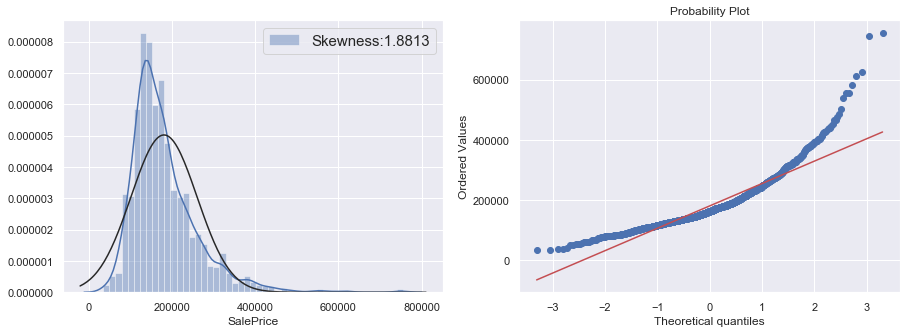

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(sale_price.dropna() , fit=stats.norm, label='Skewness:%.4f'%sale_price.skew())
plt.legend(prop={'size': 15})
plt.subplot(1,2,2)
_=stats.probplot(sale_price.dropna(), plot=plt)
sale_price.describe()

從圖上可以看出來'SalePrice'存在Skewness的問題，處理方式有很多，例如常見的Log、Log1p、BOX COX等。許多Kaggler皆使用取Log的方式，結果也還蠻不錯的(巨人的肩膀)。因此我採用取Log的方式改善。(Notice：最後預測值必須要還原成原值 )
想知道更多Skewness可以看[這裡](https://whatis.techtarget.com/definition/skewness)

count    1458.000000
mean       12.024009
std         0.399715
min        10.460242
25%        11.774713
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

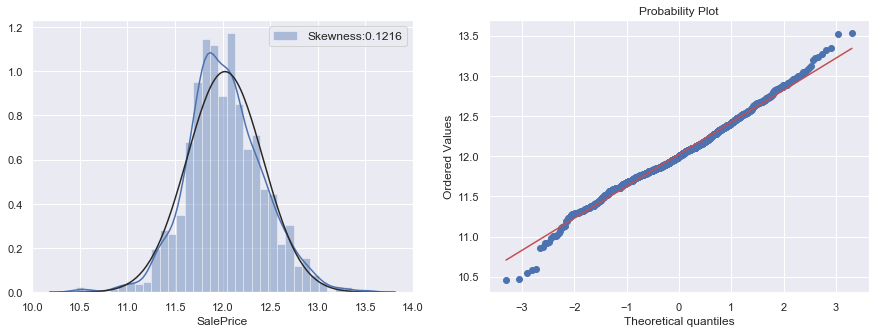

In [15]:
sale_price = np.log(sale_price)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(sale_price.dropna() , fit=stats.norm, label='Skewness:%.4f'%sale_price.skew())
plt.legend(prop={'size': 12})
plt.subplot(1,2,2)
_=stats.probplot(sale_price.dropna(), plot=plt)
sale_price.describe()

看起來好很多了，到底為什麼要對Skewness進行處理，可以參考[這裡](https://datascience.stackexchange.com/questions/20237/why-do-we-convert-skewed-data-into-a-normal-distribution)

### Numerical

當Values總類大於13時，判定為連續型變數；否則為離散型變數(這部分參考[Top 7% using ElasticNet with Interactions](https://www.kaggle.com/jack89roberts/top-7-using-elasticnet-with-interactions/notebook))。

In [16]:
cols_numerical = df_all.dtypes[df_all.dtypes != object].index
col_nunique = pd.Series(df_all[cols_numerical].nunique())
cols_discrete = col_nunique[col_nunique<13].index
cols_continuous = col_nunique[col_nunique>=13].index
cols_category = df_all.dtypes[~df_all.dtypes.index.isin(cols_numerical)].index.tolist()

#### Continuous

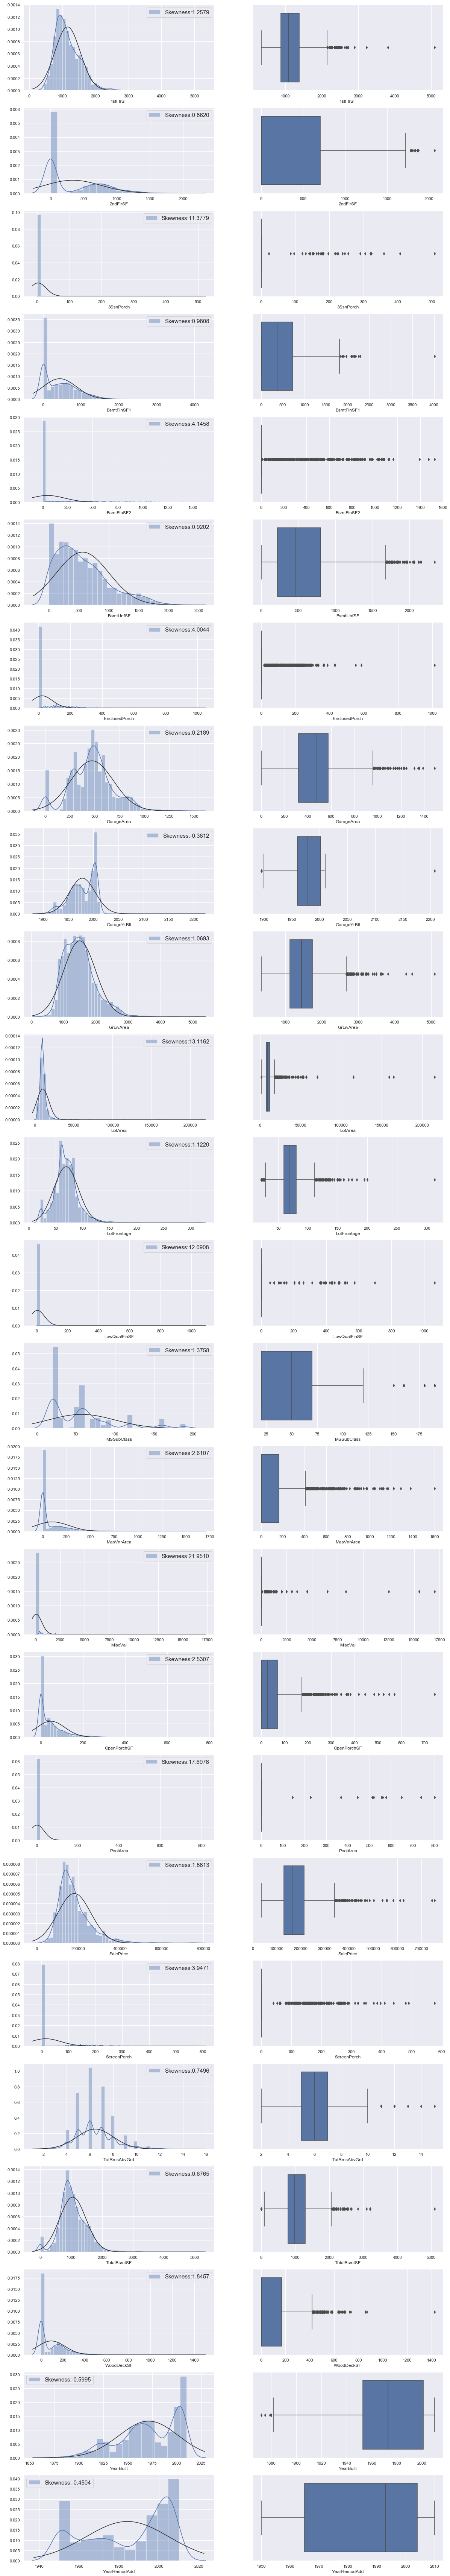

In [17]:
# figure parameters
fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(10*fcols,5*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df_all[col].dropna(), fit=stats.norm, label='Skewness:%.4f'%df_all[col].skew(), ax=ax)
    plt.xlabel(col)
    plt.legend(prop={'size': 15});
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.boxplot(df_all[col].dropna())
    plt.xlabel(col);

#### Discrete

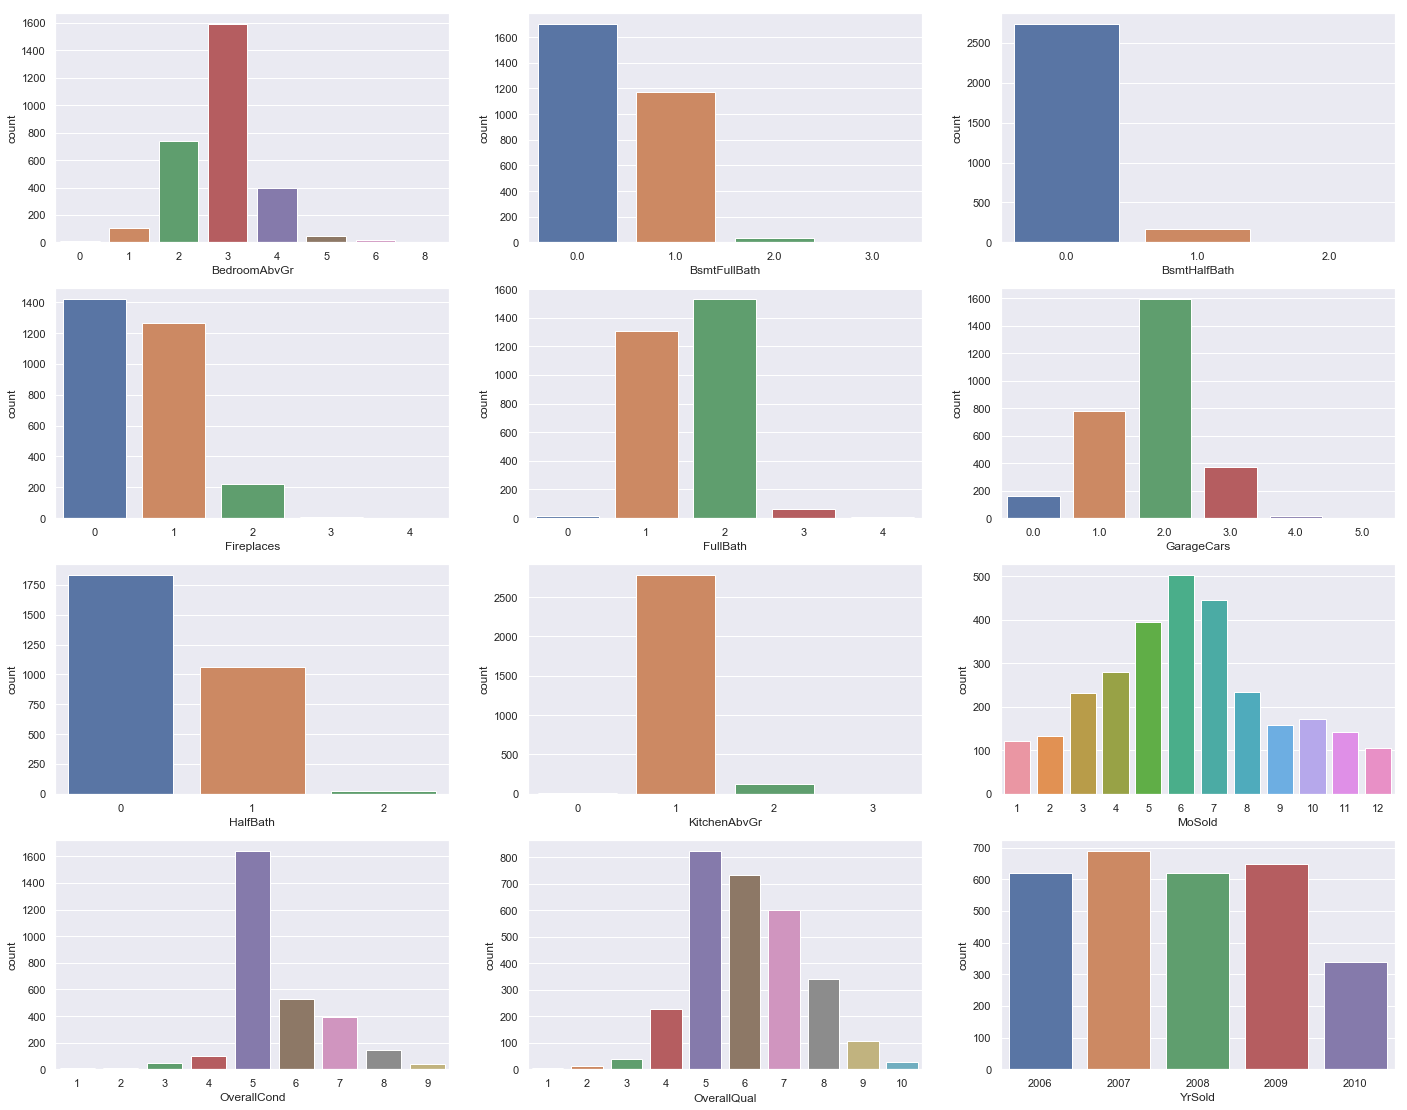

In [18]:
# figure parameters
fcols = 3
frows = len(cols_discrete)
plt.figure(figsize=(8*fcols,5*frows))

i=0
for col in cols_discrete:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.countplot(df_all[col])
    plt.xlabel(col)



### Category

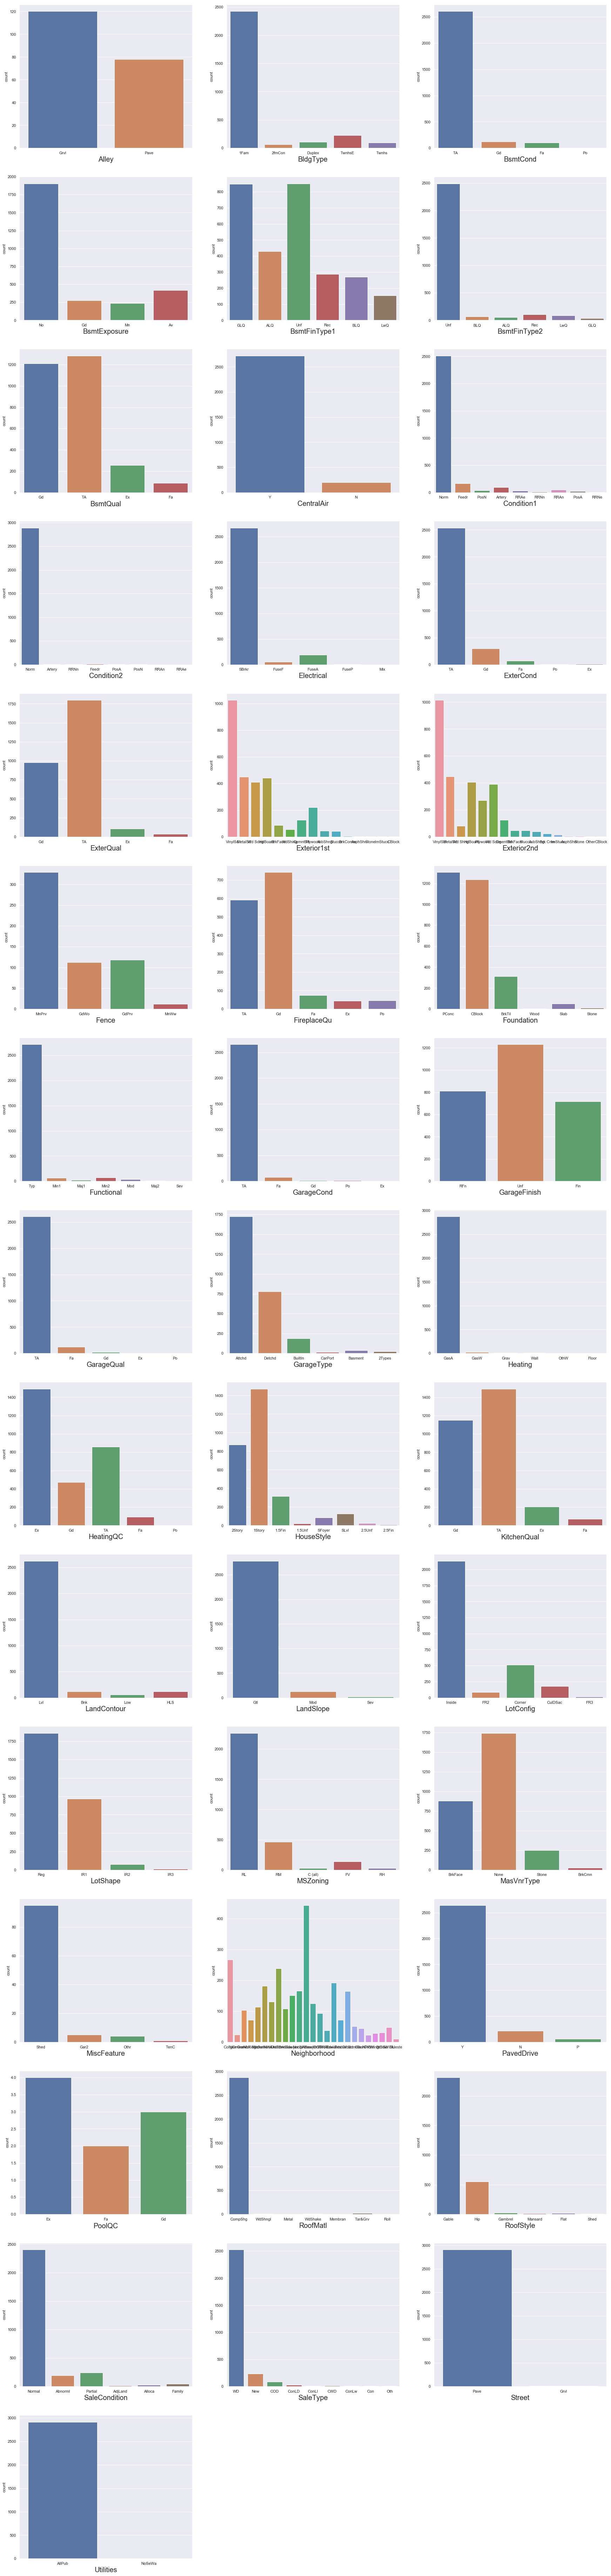

In [19]:
fcols = 3
frows = len(cols_category)
plt.figure(figsize=(10*fcols,9*frows))

i=0
for col in cols_category:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.countplot(df_all[col])
    plt.xlabel(col, fontsize=20)

接著把Target 'SalePrice'加進來看看

### Distribution of SalePrice in continuous features

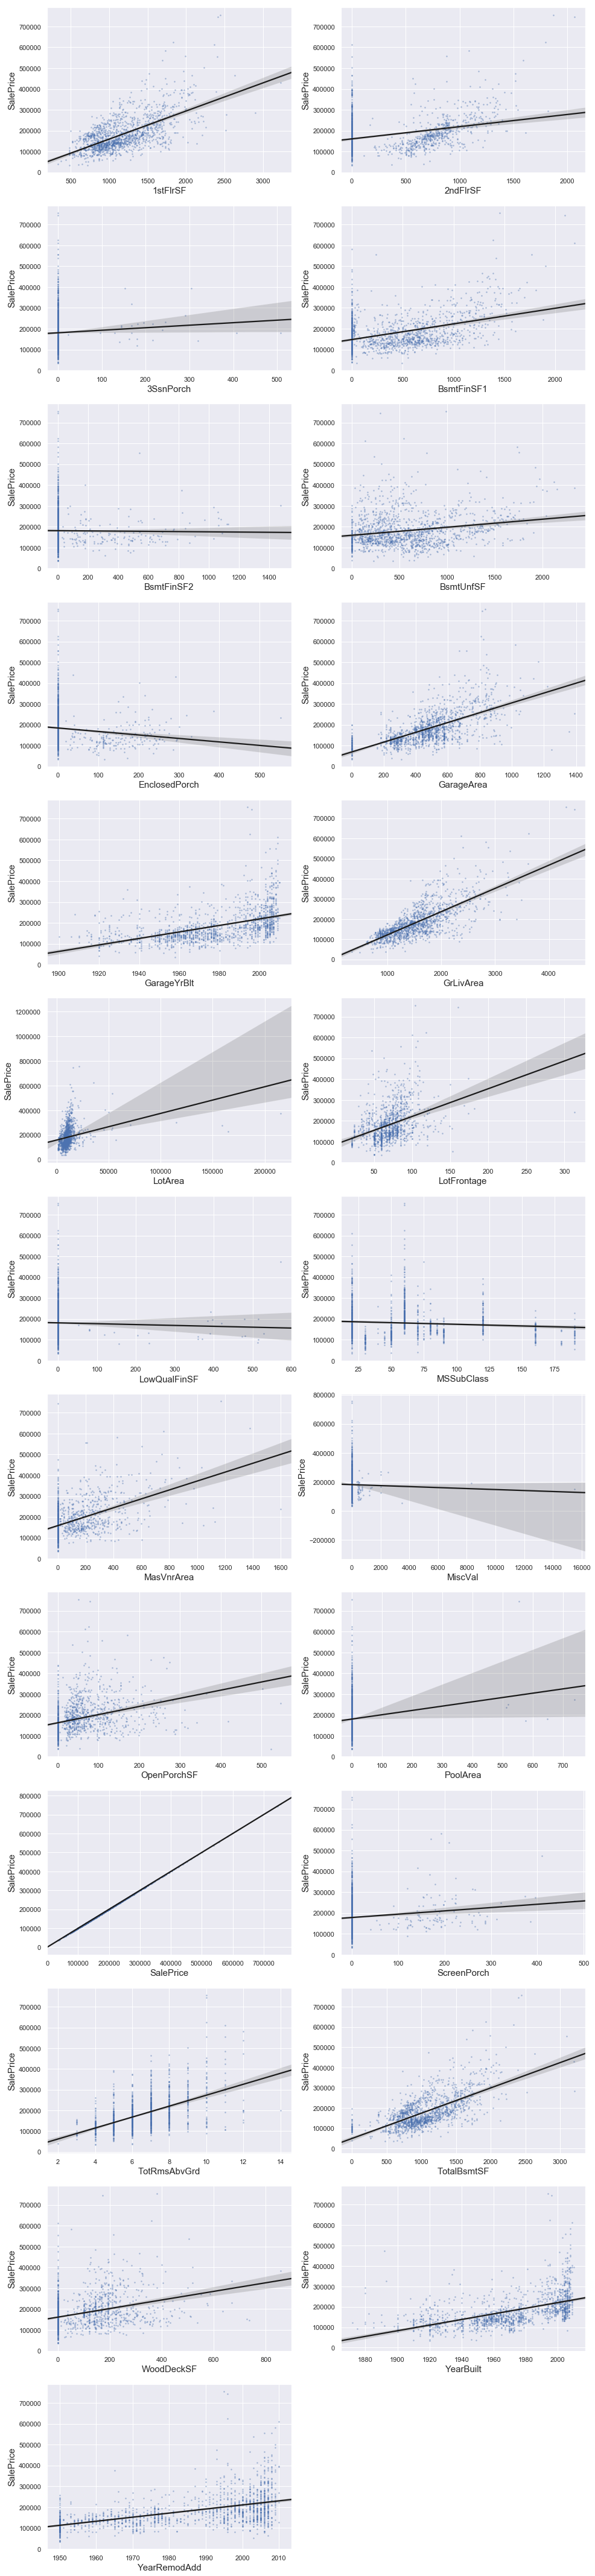

In [20]:
# figure parameters
fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(8*fcols,6*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='SalePrice', data=df_all, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col, fontsize=15)
    plt.ylabel('SalePrice', fontsize=15)
    

### Distribution of SalePrice in discrete features

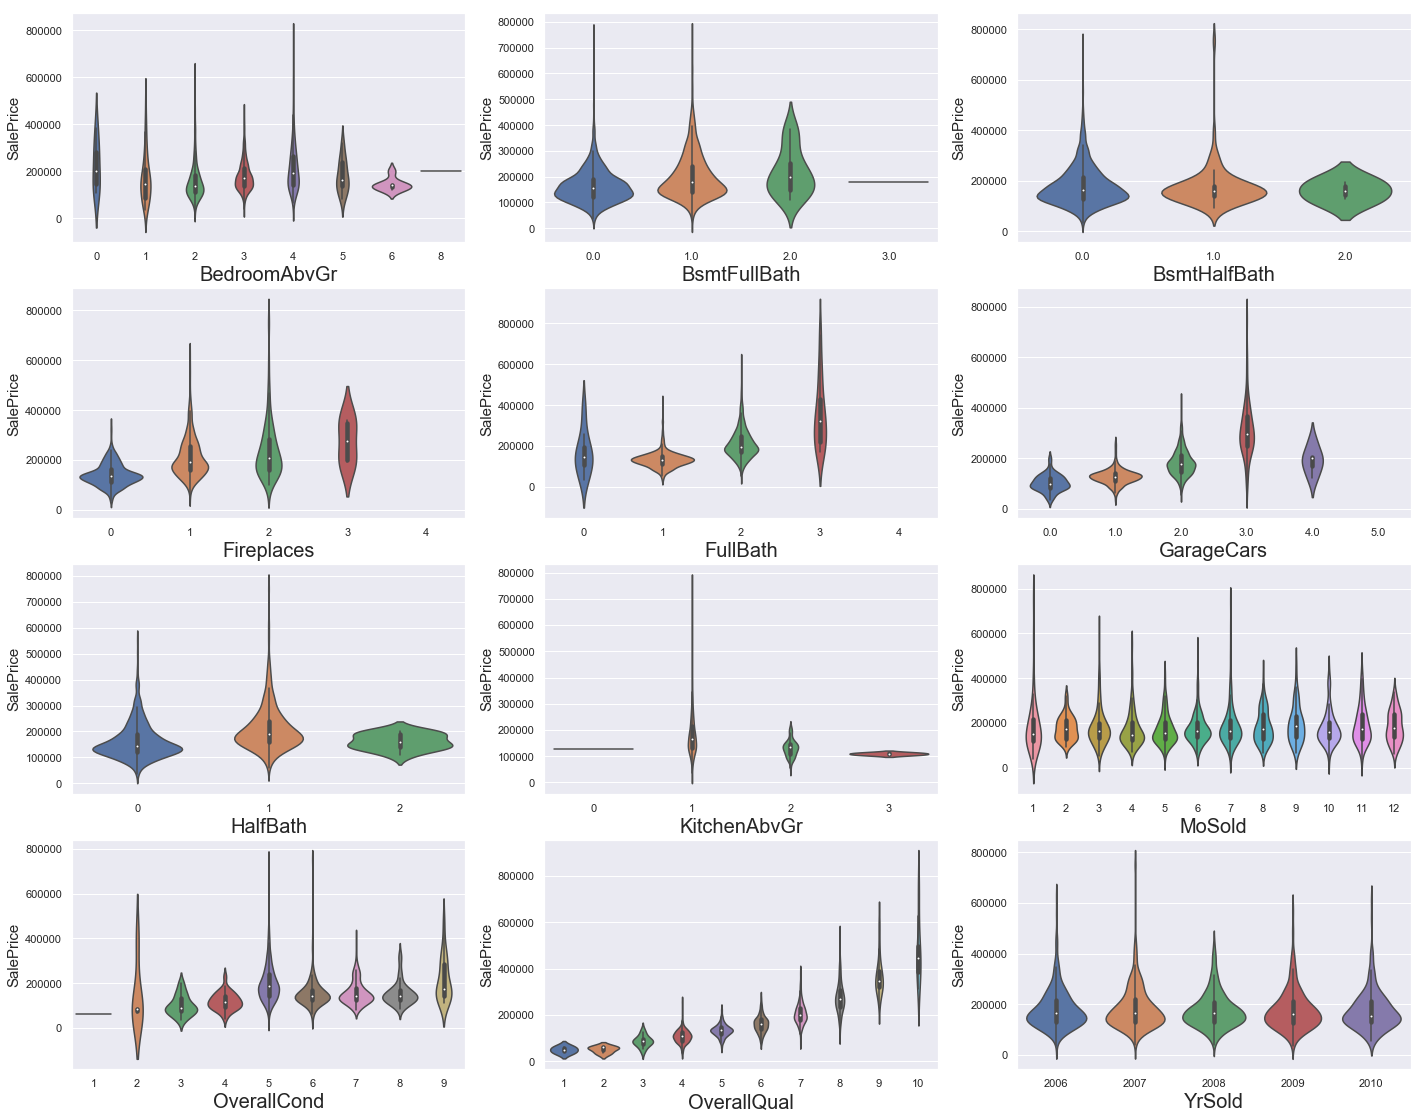

In [21]:
fcols = 3
frows = len(cols_discrete)
plt.figure(figsize=(8*fcols,5*frows))

i=0
for col in cols_discrete:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.violinplot(df_all[col],df_all['SalePrice'])
    plt.xlabel(col, fontsize=20)
    plt.ylabel('SalePrice', fontsize=15)

### Distribution of SalePrice in category features

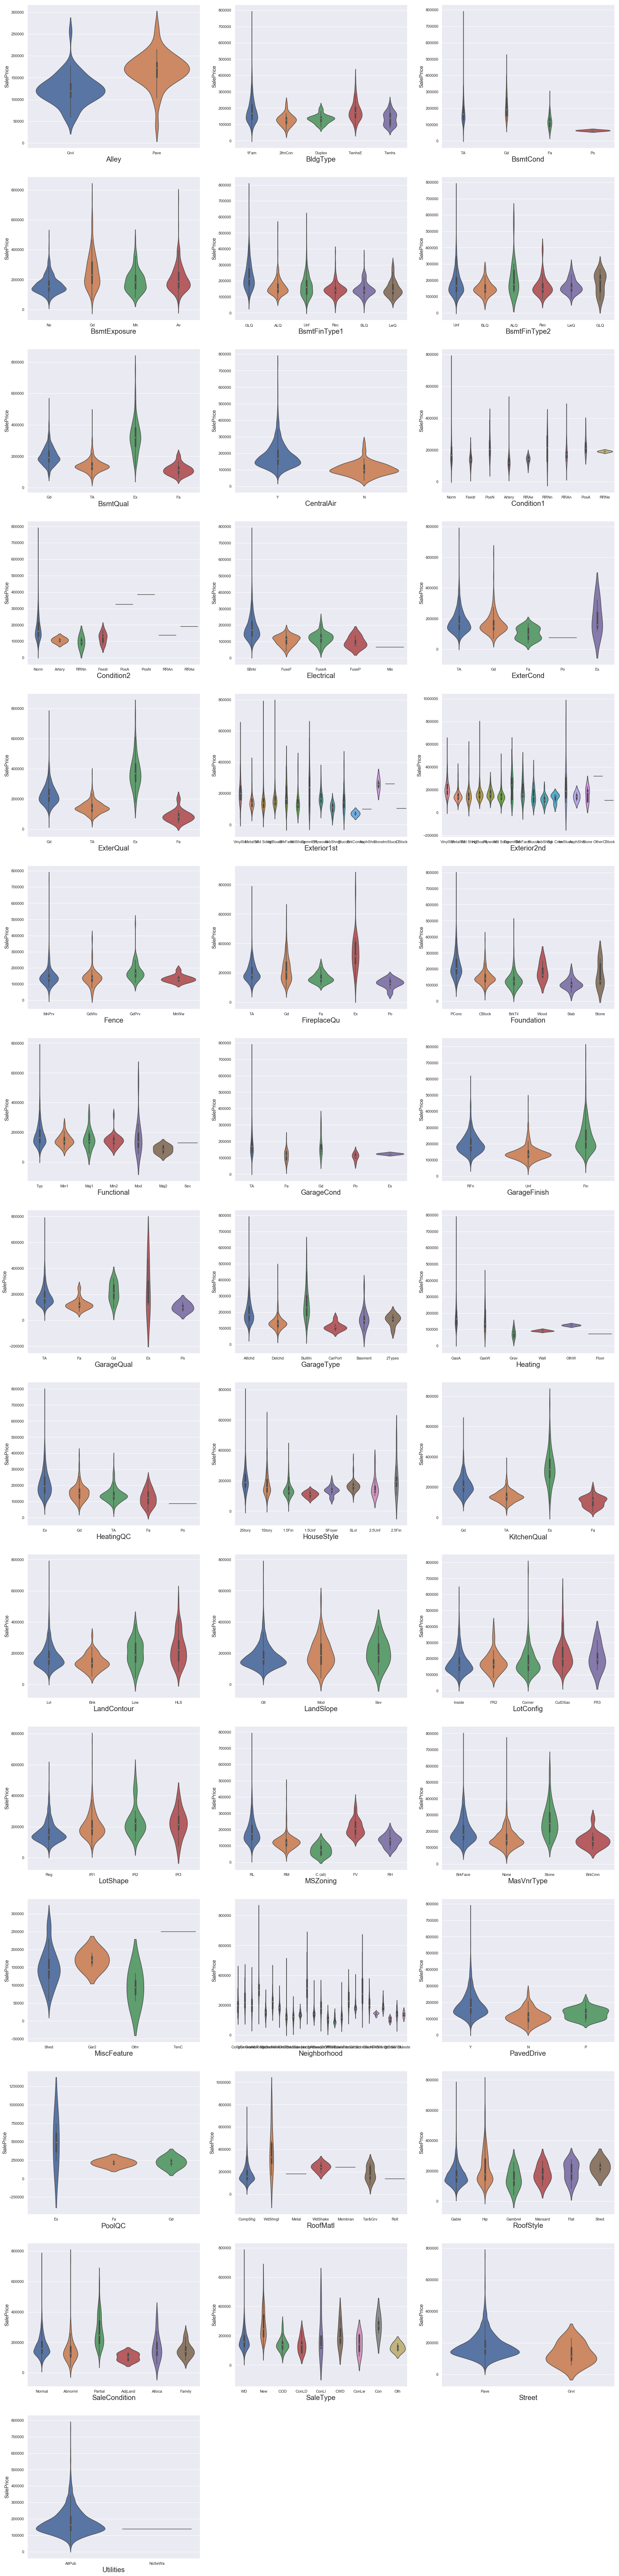

In [22]:
fcols = 3
frows = len(cols_category)
plt.figure(figsize=(10*fcols,9*frows))

i=0
for col in cols_category:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.violinplot(df_all[col],df_all['SalePrice'])
    plt.xlabel(col, fontsize=20)
    plt.ylabel('SalePrice', fontsize=15)

## Data Preprocess

### Missing Values

首先先觀察有多少項Feature包含NA資料(總共有80個欄位，因此必須要在前處花點時間了)

In [23]:
# Dealing with NA values
col_na = df_all.isnull().sum()
col_na = col_na[col_na > 0]
print(col_na.sort_values(ascending = False))

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


對於NA來說，有些欄位裡NA代表並沒有該設施，因此重新賦予新值。

In [24]:
cols_fillna = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
                   'GarageQual', 'GarageCond', 'GarageFinish', 'GarageType',
                   'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2']
for cols in cols_fillna:
    df_all[cols].fillna(value='None', inplace=True)

車庫建造時間缺值，代表它沒有建車庫，我將房屋建造時間填入。

In [25]:
df_all.loc[df_all.GarageYrBlt.isnull(), 'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(), 'YearBuilt']

沒有建造車庫，應該該處我都填入0。

In [26]:
df_all.GarageArea.fillna(0, inplace=True)
df_all.GarageCars.fillna(0, inplace=True)

欄位'MasVnrArea'代表使用磚石材值平方英尺，缺值代表沒有使用，填入0。

In [27]:
df_all['MasVnrArea'].fillna(value=0, inplace=True)

底下欄位代表地下室各方面資訊，但有些建屋並未有地下室，因此缺值我填入0。

In [28]:
df_all.BsmtFullBath.fillna(0, inplace=True)
df_all.BsmtHalfBath.fillna(0, inplace=True)
df_all.BsmtFinSF1.fillna(0, inplace=True)
df_all.BsmtFinSF2.fillna(0, inplace=True)
df_all.BsmtUnfSF.fillna(0, inplace=True)
df_all.TotalBsmtSF.fillna(0, inplace=True)

欄位'Exterior1st'、'Exterior2nd'為房屋外觀，缺值我填入'Other'。

In [29]:
df_all.Exterior1st.fillna('Other', inplace=True)
df_all.Exterior2nd.fillna('Other', inplace=True)

欄位'SaleType'代表銷售的類別，我填入Other。

In [30]:
df_all.SaleType.fillna('Other', inplace=True)

欄位'MSZoning'、'Utilities'、'Functional'、'KitchenQual'、'Electrical'由於並沒有更值觀的參考值，以及缺值少，直接填入眾數。

In [31]:
col = ['MSZoning', 'Utilities', 'Functional', 'KitchenQual', 'Electrical']
df_all.MSZoning.fillna(df_all.MSZoning.mode()[0], inplace=True)
df_all.Utilities.fillna(df_all.Utilities.mode()[0], inplace=True)
df_all.Functional.fillna(df_all.Functional.mode()[0], inplace=True)
df_all.KitchenQual.fillna(df_all.KitchenQual.mode()[0], inplace=True)
df_all.Electrical.fillna(df_all.Electrical.mode()[0], inplace=True)

欄位'LotFrontage'占了接近20%的缺值，因此我用Ridge Regression先進行一次預測，將預測值填入空缺。而為何使用的是Ridge而非LASSO可以參考[這裡](http://sofasofa.io/forum_main_post.php?postid=1000476)

In [32]:
# Standardization
def scale_standardization(col):
    return (col-col.mean())/(col.std())

In [33]:
# 宣告
df_lotf = pd.get_dummies(df_all)
df_lotf = df_lotf.drop('SalePrice', axis=1)
for col in df_lotf.drop('LotFrontage', axis=1).columns:
    df_lotf[col] = scale_standardization(df_lotf[col])
lf_train = df_lotf.dropna()
lf_train_y = lf_train.LotFrontage
lf_train_X = lf_train.drop('LotFrontage', axis=1)

In [34]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, lf_train_X, lf_train_y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

model_ridge = Ridge()
alphas = np.logspace(-3, 3, 100)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

可以看到，當Alpha接近800時它的RMSE會呈現最小值，因此Alpha便決定好了。

Text(0, 0.5, 'rmse')

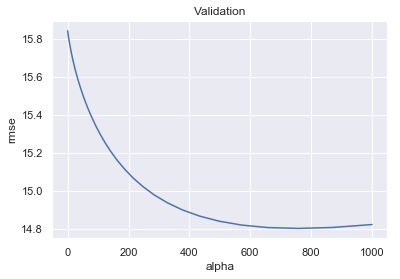

In [35]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [36]:
lasso_cv = RidgeCV(alphas=np.logspace(-3, 3, 100))
lasso_cv.fit(lf_train_X, lf_train_y)
lr = Ridge(alpha=lasso_cv.alpha_, max_iter=1000)
lr.fit(lf_train_X, lf_train_y)
lf_test = df_lotf.LotFrontage.isnull()
X = df_lotf[lf_test].drop('LotFrontage', axis=1)
y = lr.predict(X)
df_all.loc[lf_test, 'LotFrontage'] = y

做到這哩，總算是將Missing Values都處理好了。

In [37]:
df_all.info()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            2917 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2917 non-null object
BsmtExposure     2917 non-null object
BsmtFinSF1       2917 non-null float64
BsmtFinSF2       2917 non-null float64
BsmtFinType1     2917 non-null object
BsmtFinType2     2917 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2917 non-null object
BsmtUnfSF        2917 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2917 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      29

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond  \
Id                                                                        
1        856       854          0  None             3     1Fam       TA   
2       1262         0          0  None             3     1Fam       TA   
3        920       866          0  None             3     1Fam       TA   
4        961       756          0  None             3     1Fam       Gd   
5       1145      1053          0  None             4     1Fam       TA   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2  ...   SaleType ScreenPorch  Street  \
Id                                       ...                                  
1            No       706.0         0.0  ...         WD           0    Pave   
2            Gd       978.0         0.0  ...         WD           0    Pave   
3            Mn       486.0         0.0  ...         WD           0    Pave   
4            No       216.0         0.0  ...         WD           0    Pave   
5            Av       655.0         0.0  ...         WD           0    Pave   

    TotRmsAbvGrd TotalBsmtSF  Utilities WoodDeckSF YearBuilt YearRemodAdd  \
Id                                                                          
1              8       856.0     AllPub          0      2003         2003   
2              6      1262.0     AllPub        298      1976         1976   
3              6       920.0     AllPub          0      2001         2002   
4              7       756.0     AllPub          0      1915         1970   
5              9      1145.0     AllPub        192      2000         2000   

   YrSold  
Id         
1    2008  
2    2007  
3    2008  
4    2006  
5    2008  

[5 rows x 80 columns]

### Transfer discrete into category

對於某些離散值來說，它存在位階，因此先將全部轉換成數值型態。

In [38]:
cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
                 'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
                'GarageCond','PoolQC']
dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}
for col in cols_ExGd:
    df_all[col].replace(dict_ExGd, inplace=True)

In [39]:
# Remaining columns
df_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)
df_all['CentralAir'].replace({'Y':1,'N':0}, inplace=True)
df_all['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)
df_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)
df_all['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)
df_all['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)
df_all['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

### Skewness

對於線性回歸來說，除了共線性[Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)外方差齊性[Homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity)也很重要，因此對於Skewness資料來說是必須要處理的。

In [40]:
df_num = df_all.dtypes[df_all.dtypes != object].index

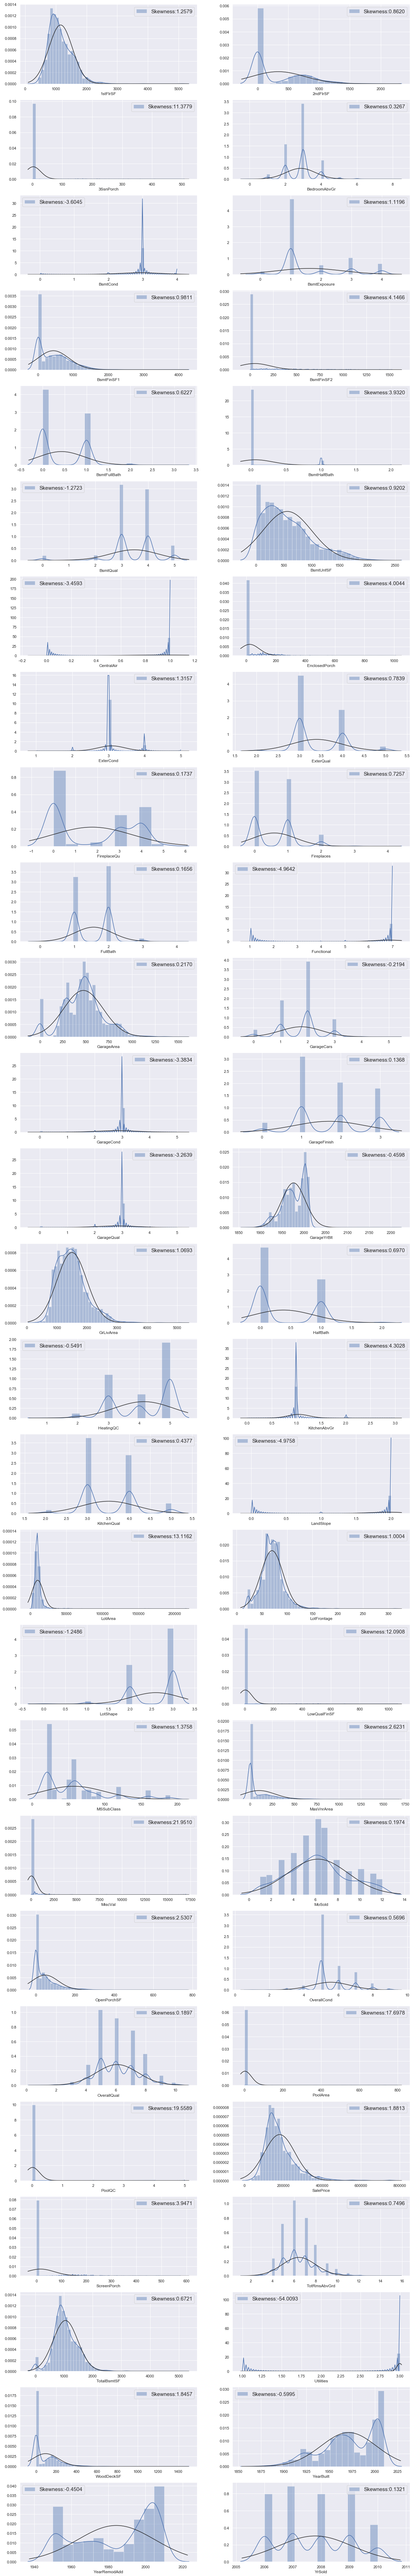

In [41]:
# figure parameters
fcols = 2
frows = len(df_num)
plt.figure(figsize=(10*fcols,5*frows))

i=0
for col in df_num:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df_all[col].dropna(), fit=stats.norm, label='Skewness:%.4f'%df_all[col].skew(), ax=ax)
    plt.xlabel(col)
    plt.legend(prop={'size': 15});
    

In [42]:
skew_feature = np.abs(df_all[df_num][:2917].skew()).sort_values(ascending=False)
skew_feature = skew_feature[skew_feature > 0.2].index
# Box Cox
for skew in skew_feature:
    df_all[skew] = boxcox1p(df_all[skew], 0.15)

為了讓資料單位一致，我會將資料進行正規化。

In [43]:
# Standardization numeric data
df_all[df_num] = df_all[df_num].apply(scale_standardization, axis=0)

In [44]:
# one-hot encode
# processing data with one-hot encode：一個方法讓各屬性距離原點是相同距離(使資料沒有階級)
# select which features to use (all for now)
model_cols = df_all.columns
# encode categoricals
df_model = pd.get_dummies(df_all)
# Rather than including Condition1 and Condition2, or Exterior1st and Exterior2nd,
# combine the dummy variables (allowing 2 true values per property)
if ('Condition1' in model_cols) and ('Condition2' in model_cols):
    cond_suffix = ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn']
    for suffix in cond_suffix:
        col_cond1 = 'Condition1_' + suffix
        col_cond2 = 'Condition2_' + suffix
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2, axis=1, inplace=True)
if ('Exterior1st' in model_cols) and ('Exterior2nd' in model_cols):
    # some different strings in Exterior1st and Exterior2nd for same type - rename columns to correct
    df_model.rename(columns={'Exterior2nd_Wd Shng': 'Exterior2nd_WdShing',
                             'Exterior2nd_Brk Cmn': 'Exterior2nd_BrkComm',
                             'Exterior2nd_CmentBd': 'Exterior2nd_CemntBd'}, inplace=True)
    ext_suffix = ['AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd',
                  'HdBoard', 'ImStucc', 'MetalSd', 'Plywood', 'Stone',
                  'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing', 'AsbShng']
    for suffix in ext_suffix:
        col_cond1 = 'Exterior1st_' + suffix
        col_cond2 = 'Exterior2nd_' + suffix
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2, axis=1, inplace=True)

對於處理Outlier資料，這裡我先定義如何找到Outlier，接著跑Ridge Regression，當預測 y 大於3倍標準差時，判斷為Outlier。

In [45]:
def find_outliers(model, X, y, sigma=3):
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=y.index)
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid) / std_resid
    outliers = z[abs(z) > sigma].index
    return outliers

In [46]:
X = df_model.iloc[:1458, :]
y = sale_price
outliers = find_outliers(Ridge(), X, y)
outliers
df_model = df_model.drop(outliers)
sale_price = sale_price.drop(outliers)

In [47]:
df_model = df_model.drop('SalePrice', axis=1)
processed_train = df_model.iloc[:1432, :]
processed_test = df_model.iloc[1432:, :]

In [48]:
processed_train.head()

1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  \
Id                                                                        
1  -0.786066  1.215126  -0.112332      0.251301  0.167517     -0.552090   
2   0.408921 -0.859467  -0.112332      0.251301  0.167517      1.997647   
3  -0.569362  1.221945  -0.112332      0.251301  0.167517      0.533091   
4  -0.437172  1.156171  -0.112332      0.251301  1.198754     -0.552090   
5   0.102812  1.319009  -0.112332      1.273155  0.167517      1.344062   

    BsmtFinSF1  BsmtFinSF2  BsmtFullBath  BsmtHalfBath     ...       \
Id                                                         ...        
1     0.802023   -0.358097      1.132478     -0.251419     ...        
2     0.976249   -0.358097     -0.832351      3.879425     ...        
3     0.612672   -0.358097      1.132478     -0.251419     ...        
4     0.236683   -0.358097      1.132478     -0.251419     ...        
5     0.763138   -0.358097      1.132478     -0.251419     ...        

    SaleType_Con  SaleType_ConLD  SaleType_ConLI  SaleType_ConLw  \
Id                                                                 
1              0               0               0               0   
2              0               0               0               0   
3              0               0               0               0   
4              0               0               0               0   
5              0               0               0               0   

    SaleType_New  SaleType_Oth  SaleType_Other  SaleType_WD  Street_Grvl  \
Id                                                                         
1              0             0               0            1            0   
2              0             0               0            1            0   
3              0             0               0            1            0   
4              0             0               0            1            0   
5              0             0               0            1            0   

    Street_Pave  
Id               
1             1  
2             1  
3             1  
4             1  
5             1  

[5 rows x 220 columns]

## Modeling Data

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection

In [50]:
# Split data
X = processed_train
y = sale_price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)

我選了常見的9個回歸模型(當然要想在新增也可以)

In [51]:
result = []
regression = []
regression.append(['LinearRegression', LinearRegression()])
regression.append(['Lasso', Lasso()])
regression.append(['Ridge', Ridge()])
regression.append(['ElasticNet', ElasticNet()])
regression.append(['RandomForest', RandomForestRegressor()])
regression.append(['GradientBoostingRegressor', GradientBoostingRegressor()])
regression.append(['XgBoost', XGBRegressor()])
regression.append(['SVR', SVR()])
regression.append(['LinearSVR', LinearSVR()])

接著我直接將9個模型調整參數(用GridSearchCV())。

In [52]:
grid_para = [
    # LinearRegression
    [{
    }],

    # Lasso
    [{
        'alpha': [0.01, 0.1, 0.5, 0.75, 1, 5, 50, 100]
    }],

    # Ridge
    [{
        'alpha': [0.01, 0.1, 0.5, 0.75, 1, 5, 50, 100]
    }],

    # ElasticNet
    [{
        'alpha': [0.01, 0.1, 0.5, 0.75, 1, 5, 50, 100],
        'l1_ratio': [0.01, 0.1, 0.5, 0.9, 0.99] # l1_ratio = 0 代表使用 Lasso
    }],

    # RandomForest
    [{
        'n_estimators': [300]
    }],

    # GradientBoostingRegressor
    [{
        'n_estimators': [300],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'min_samples_split': range(2, 6, 1)
    }],

    # XgBoost
    [{
        'n_estimators': [300],
        'max_depth': range(1, 15, 1)
    }],
    # SVR
    [{
        'C': range(1, 21, 2),
        'kernel': ['poly', 'rbf', 'sigmoid'],
    }],
    # LinearSVR
    [{
        'C': np.arange(0.1, 1, 0.1),
        'max_iter': [5000]
    }],

]

In [63]:
def BasedLines(X_train, y_train, regression, grid_para):
    result = []
    results = []
    names = []

    for reg, para in zip(regression, grid_para):
        best_search = model_selection.GridSearchCV(estimator=reg[1]
                                                   , param_grid=para, scoring='neg_mean_squared_error', n_jobs=-1)
        best_search.fit(X, y)
        result.append([reg[0], best_search.best_estimator_])

    for name, model in result:
        kfold = RepeatedKFold(n_splits=10, n_repeats=5)
        cv_result = -cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
        results.append(cv_result)
        names.append(name)
    return names, results, result
def Score(names, results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:." + str(dec) + "f}"
        return float(prc.format(f_val))
    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(), 6))
    scoreDataFrame = pd.DataFrame({'Model': names, 'RMSE': scores})
    return print(scoreDataFrame.sort_values('RMSE')[0:5])

In [64]:
names, results, result = BasedLines(X, y, regression, grid_para)
Score(names, results)

                       Model      RMSE
2                      Ridge  0.009831
3                 ElasticNet  0.009937
6                    XgBoost  0.010969
5  GradientBoostingRegressor  0.011045
7                        SVR  0.011488


前五名RMSE最低的模型。

In [65]:
sta = StackingRegressor(regressors=[result[2][1], result[3][1], result[6][1],
                                    result[5][1], result[7][1]], meta_regressor=result[2][1])
fin_pred = sta.fit(X_train, y_train).predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, fin_pred))

Mean Squared Error: 0.009127043967020961


Stack的結果：0.009127043967020961，可以看出比起第一名 Ridge進步一些，接著輸出。

In [66]:
fin_pred = sta.fit(X, y).predict(processed_test)
y_pred = np.exp(fin_pred)
y_pred = pd.DataFrame({'Id': range(1461, 2920, 1), 'SalePrice': y_pred})
y_pred.to_csv('D:/kaggle/House Price/sample_submission1.csv', index=False)